<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Ligand Refinement in PyRosetta (a.k.a. High-Resolution Local Docking) Using the `ligand.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.00-Ligand-Docking-PyRosetta.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [`GALigandDock` Protocol with `pyrosetta.distributed` Using the `beta_cart.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.01-Ligand-Docking-XMLObjects.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Global Ligand Docking using `XMLObjects` Using the `ref2015.wts` Scorefunction

*Warning*: This notebook uses `pyrosetta.distributed.viewer` code, which runs in `jupyter notebook` and might not run if you're using `jupyterlab`.

*Note:* This Jupyter notebook requires the PyRosetta distributed layer. Please make sure to activate the `PyRosetta.notebooks` conda environment before running this notebook. The kernel is set to use this environment. 

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
%matplotlib inline
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys

# Notebook setup
import sys
if 'google.colab' in sys.modules:
   print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
   sys.exit(0)

Now we change the scorefunction to `ref2015.wts`, the weights of which were optimized on ligands with AM1-BCC partial charges generated with Amber's `antechamber`. Therefore, the Rosetta `.params` file should ideally also have AM1-BCC partial charges generated with `antechamber`.

In [2]:
ligand_params = "inputs/TPA.am1-bcc.fa.params"
flags = f"""
-ignore_unrecognized_res 1
-extra_res_fa {ligand_params}
"""
pyrosetta.distributed.init(flags)
pose = pyrosetta.io.pose_from_file(filename="inputs/test_lig.pdb")
scorefxn = pyrosetta.create_score_function("ref2015")

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-ignore_unrecognized_res 1 -extra_res_fa inputs/TPA.am1-bcc.fa.params', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
INFO:rosetta:core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
INFO:rosetta:core.init: {0} Rosetta version: PyRosetta4.conda.linux.CentOS.python36.Release r233 2019.39+release.93456a5 93456a567a8125cafdf7f8cb44400bc20b570d81 http://www.pyrosetta.org 2019-09-26T14:24:44
INFO:rosetta:core.init: {0} command: PyRosetta -ex1 -ex2aro -i

Ligand docking using `XmlObjects`:

In [3]:
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
  </SCOREFXNS>
  <RESIDUE_SELECTORS>
    <Chain name="chX" chains="X"/>
  </RESIDUE_SELECTORS>
  <SIMPLE_METRICS>
    <RMSDMetric name="rmsd_chX" residue_selector="chX" reference_name="store_native" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
  </SIMPLE_METRICS>
  <SCORINGGRIDS ligand_chain="X" width="25">
    <ClassicGrid grid_name="vdw" weight="1.0"/>
  </SCORINGGRIDS>
  <LIGAND_AREAS>
    <LigandArea name="docking_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true" minimize_ligand="10"/>
    <LigandArea name="final_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true"/>
    <LigandArea name="final_backbone_X" chain="X" cutoff="7.0" add_nbr_radius="false" all_atom_mode="true" Calpha_restraints="0.3"/>
  </LIGAND_AREAS>
  <INTERFACE_BUILDERS>
    <InterfaceBuilder name="side_chain_for_docking" ligand_areas="docking_sidechain_X"/>
    <InterfaceBuilder name="side_chain_for_final" ligand_areas="final_sidechain_X"/>
    <InterfaceBuilder name="backbone" ligand_areas="final_backbone_X" extension_window="3"/>
  </INTERFACE_BUILDERS>
  <MOVEMAP_BUILDERS>
    <MoveMapBuilder name="docking" sc_interface="side_chain_for_docking" minimize_water="true"/>
    <MoveMapBuilder name="final" sc_interface="side_chain_for_final" bb_interface="backbone" minimize_water="true"/>
  </MOVEMAP_BUILDERS>
  <MOVERS>
    <SavePoseMover name="spm" restore_pose="0" reference_name="store_native"/>
    <Transform name="transform" chain="X" box_size="20.0" move_distance="10" angle="360" initial_perturb="2" cycles="500" repeats="5" temperature="1000"/>
    <HighResDocker name="high_res_docker" cycles="9" repack_every_Nth="3" scorefxn="fa_standard" movemap_builder="docking"/>
    <FinalMinimizer name="final" scorefxn="fa_standard" movemap_builder="final"/>
  </MOVERS>
  <FILTERS>
      <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
      <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
  </FILTERS>
  <PROTOCOLS>
    <Add mover="spm"/>
    <Add mover="transform"/>
    <Add mover="high_res_docker"/>
    <Add mover="final"/>
    <Add filter="interfE"/>
    <Add filter="rmsd_chX"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
""").get_mover("ParsedProtocol")

INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Generating XML Schema for rosetta_scripts...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Initializing schema validator...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Validating input script...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Parsed script:
<ROSETTASCRIPTS>
	<SCOREFXNS>
		<ScoreFunction name="fa_standard" weights="ref2015.wts"/>
	</SCOREFXNS>
	<RESIDUE_SELECTORS>
		<Chain chains="X" name="chX"/>
	</RESIDUE_SELECTORS>
	<SIMPLE_METRICS>
		<RMSDMetric name="rmsd_chX" reference_name="store_native" residue_selector="chX" residue_selector_ref="chX" rmsd_type="rmsd_all" robust="true"/>
	</SIMPLE_METRICS>
	<SCORINGGRIDS ligand_chain="X" width

INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} added mover "NULL_MOVER" with filter "interfE"
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} added mover "NULL_MOVER" with filter "rmsd_chX"


Produce 5 global ligand docking trajectories using `PyJobDistributor`:

In [4]:
if not os.getenv("DEBUG"):
    working_dir = os.getcwd()
    output_dir = "outputs"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    os.chdir(output_dir)

    jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name="test_lig_XMLObjects",
                                                              nstruct=5,
                                                              scorefxn=scorefxn)
    jd.native_pose = pose
    df = pd.DataFrame()
    while not jd.job_complete:
        test_pose = pose.clone()
        xml.apply(test_pose)
        test_df = pd.DataFrame.from_records(dict(test_pose.scores), index=[jd.current_name])
        df = df.append(test_df)
        jd.output_decoy(test_pose)
    os.chdir(working_dir)

INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER SavePoseMover - spm=======================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER Transform - transform=======================
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} [ WARNING ] option -qsar:grid_dir is not set.  Use this flag to specify a directory to store scoring grids.  This will save you a huge amount of time
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} No conformation matching hash: 4dc5d457f2bb8b129abbf363feeefd56e18fe3d2 Updating grid and adding it to the cache


Working on decoy: test_lig_XMLObjects_1.pdb


INFO:rosetta:protocols.ligand_docking.Transform: {0} Considering 9 conformers during sampling
INFO:rosetta:protocols.ligand_docking.Transform: {0} percent acceptance: 1433 0.5732 1067
INFO:rosetta:protocols.ligand_docking.Transform: {0} Moves rejected for being outside of grid: 1063  0.4252
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ] A large number of moves were rejected for being outside the grid. You likely want to reexamine your settings.
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ]     For the current settings, a grid size of at least 259.2    and a box size of at least 243.2 are recommended.
INFO:rosetta:protocols.evaluation.ChiWellRmsdEvaluatorCreator: {0} Evaluation Creator active ...
INFO:rosetta:protocols.ligand_docking.Transform: {0} Accepted pose with grid score: -34
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER HighResDocker - high_res_docker=======================
INFO:rosetta:basic.io

INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol.REPORT: {0} ============Begin report for rmsd_chX==================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol.REPORT: {0} ============End report for rmsd_chX==================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER SavePoseMover - spm=======================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER Transform - transform=======================
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} Found a conformation matching hash: 4dc5d457f2bb8b129abbf363feeefd56e18fe3d2 Loading from grid cache
INFO:rosetta:protocols.ligand_docking.Transform: {0} Considering 9 conformers during sampling
INFO:rosetta:protocols.ligand_docking.Transform: {0} percent acceptance: 1353 0.5412 1147
INFO:rosetta:protocols.ligand_docking.Transform: {0} Moves rejected for being outside of grid: 1144  0.4576
INFO:rosetta:protocols.ligand_d

Working on decoy: test_lig_XMLObjects_2.pdb


INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 1285 rotamers at 47 positions.
INFO:rosetta:core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 700 rotamers at 25 positions.
INFO:rosetta:core.pack.interactio

INFO:rosetta:protocols.ligand_docking.Transform: {0} Accepted pose with grid score: -20
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER HighResDocker - high_res_docker=======================


Working on decoy: test_lig_XMLObjects_3.pdb


INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 1342 rotamers at 48 positions.
INFO:rosetta:core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 1163 rotamers at 42 positions.
INFO:rosetta:core.pack.interacti

INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol.REPORT: {0} ============Begin report for rmsd_chX==================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol.REPORT: {0} ============End report for rmsd_chX==================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER SavePoseMover - spm=======================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER Transform - transform=======================
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} Found a conformation matching hash: 4dc5d457f2bb8b129abbf363feeefd56e18fe3d2 Loading from grid cache
INFO:rosetta:protocols.ligand_docking.Transform: {0} Considering 9 conformers during sampling
INFO:rosetta:protocols.ligand_docking.Transform: {0} percent acceptance: 1349 0.5396 1151
INFO:rosetta:protocols.ligand_docking.Transform: {0} Moves rejected for being outside of grid: 1150  0.46
INFO:rosetta:protocols.ligand_doc

Working on decoy: test_lig_XMLObjects_0.pdb


INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 1219 rotamers at 44 positions.
INFO:rosetta:core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 933 rotamers at 38 positions.
INFO:rosetta:core.pack.interactio

INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ] A large number of moves were rejected for being outside the grid. You likely want to reexamine your settings.
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ]     For the current settings, a grid size of at least 253.2    and a box size of at least 237.2 are recommended.
INFO:rosetta:protocols.ligand_docking.Transform: {0} Accepted pose with grid score: -20
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER HighResDocker - high_res_docker=======================


Working on decoy: test_lig_XMLObjects_4.pdb


INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 1013 rotamers at 35 positions.
INFO:rosetta:core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.task: {0} Packer task: initialize from command line()
INFO:rosetta:core.pack.rotamer_set.RotamerSet_: {0} Using simple Rotamer generation logic for TPA
INFO:rosetta:core.pack.pack_rotamers: {0} built 959 rotamers at 33 positions.
INFO:rosetta:core.pack.interactio

Now that we have sampled some global ligand docking trajectories, let's plot the ligand binding energy landscape:

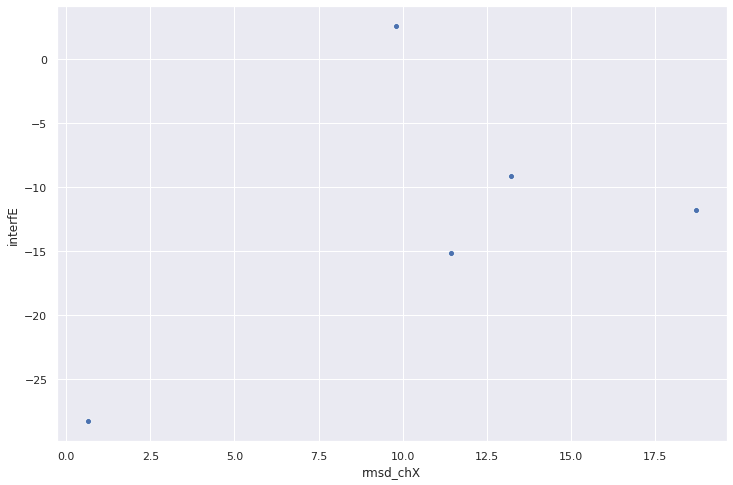

In [5]:
#Skip for tests (as DF is not present)
if not os.getenv("DEBUG"):
    matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
    seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)

We can check which `.pdb` file has the lowest `interfE` score:

In [6]:
#Skip for tests
if not os.getenv("DEBUG"):
    df.sort_values(by="interfE")

,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,...,interfE,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,rmsd_chX,total_score,yhh_planarity
test_lig_XMLObjects_1.pdb,0.0,-2141.790247,2839.589602,-505.303161,1549.888068,90.394684,1355.538397,1338.970707,-52.121705,-49.476625,...,-28.276440,-50.974895,16.443889,-84.493475,91.445419,117.822680,81.74634,0.631487,1456.971339,1.100056
test_lig_XMLObjects_4.pdb,0.0,-2117.511239,3002.017883,-484.395373,1575.126871,91.668637,1434.239151,1329.615403,-48.468502,-47.234071,...,-15.162686,-49.593810,-1.135463,-85.518547,68.279343,118.636338,81.74634,11.435035,1628.146163,0.366937
test_lig_XMLObjects_0.pdb,0.0,-2101.634782,2881.724947,-484.021972,1552.937939,90.957571,1395.967000,1307.276630,-48.113076,-47.985689,...,-11.798166,-48.713822,-0.016234,-86.665216,73.794018,111.035818,81.74634,18.723389,1519.846938,0.360842
test_lig_XMLObjects_2.pdb,0.0,-2108.199196,2995.956828,-483.697206,1572.754514,91.583322,1441.994818,1317.274987,-47.207246,-47.496493,...,-9.164489,-48.398568,3.595816,-82.205583,73.140703,122.270933,81.74634,13.237048,1642.356614,0.294935
test_lig_XMLObjects_3.pdb,0.0,-2114.363249,2941.806947,-471.461845,1563.092110,90.772894,1426.594993,1318.093586,-47.347564,-48.064493,...,2.542285,-49.704318,4.201275,-83.261999,68.786798,117.522522,81.74634,9.790556,1591.672471,0.122519


Let's take a look at the pose with the lowest `interfE` value that was generated:

In [8]:
#Skip for tests
if not os.getenv("DEBUG"):
    lowest_energy_pdb_filename = os.path.join("expected_outputs", df.sort_values(by="interfE").head(1).index[0])
    test_pose = pyrosetta.io.pose_from_file(filename=lowest_energy_pdb_filename)

    chE = pyrosetta.rosetta.core.select.residue_selector.ChainSelector("E")

    view = viewer.init(test_pose)
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
    view.add(viewer.setSurface(residue_selector=chE, opacity=0.7, color='white'))
    view.add(viewer.setHydrogenBonds())
    view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

*Exercise:*

Re-run the above example with more sampling. *Pretend* that you have done enough sampling (i.e. ~2,000-10,000 global ligand docking trajectories depending on the surface area of the protein) and that the decoy with the lowest `interfE` score is the "native" ligand binding mode. Re-plot the ligand binding energy landscape fixing that decoy to `rmsd_chX`=0.0

*Hint:* You have all of the decoys saved as `.pdb` files, so you need to re-score them using the command line flag `-in:file:native` specifying the `.pdb` file with the lowest `interfE` score, that way all `rmsd_chX` values correspond to the RMSD from that decoy, not the binding mode we started with above. Use the following cell to get started! The code below does not save the new scores to a scorefile, but if you would like to, make use of  the `pyrosetta.toolbox.py_jobdistributor.output_scorefile()` function.

***
*Restart Jupyter Notebook kernel to properly re-initialize PyRosetta*
***

In [1]:
import glob
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
%matplotlib inline
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys

# Notebook setup
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-extra_res_fa inputs/TPA.am1-bcc.fa.params -in:file:native expected_outputs/test_lig_XMLObjects_1.pdb -ignore_unrecognized_res 1 -mute all', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


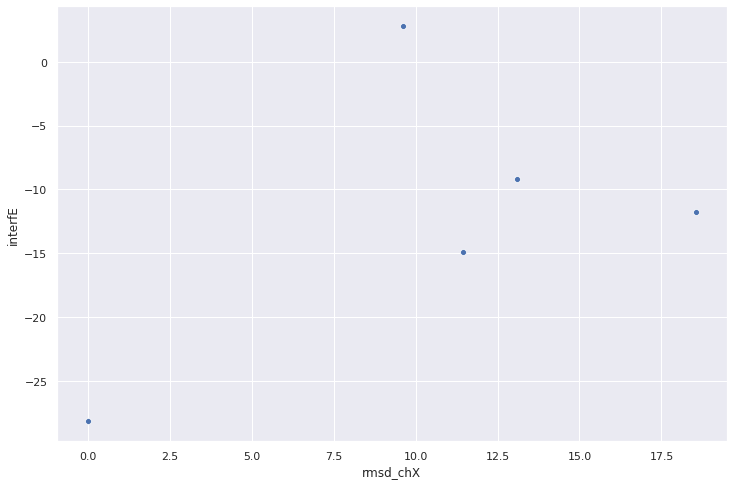

In [2]:
if not os.getenv("DEBUG"):
    pdb_filenames = glob.glob("expected_outputs/test_lig_XMLObjects*.pdb")
    ligand_params = "inputs/TPA.am1-bcc.fa.params"
    native_pdb_filename = "expected_outputs/test_lig_XMLObjects_1.pdb"

    flags = f"""
    -extra_res_fa {ligand_params} 
    -in:file:native {native_pdb_filename}
    -ignore_unrecognized_res 1 
    -mute all
    """
    pyrosetta.distributed.init(flags)
    scorefxn = pyrosetta.create_score_function("ref2015")

    xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
      <SCOREFXNS>
        <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
      </SCOREFXNS>
      <RESIDUE_SELECTORS>
        <Chain name="chX" chains="X"/>
      </RESIDUE_SELECTORS>
      <SIMPLE_METRICS>
        <RMSDMetric name="rmsd_chX" use_native="true" residue_selector="chX" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
      </SIMPLE_METRICS>
      <FILTERS>
          <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
          <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
      </FILTERS>
      <PROTOCOLS>
        <Add filter="interfE"/>
        <Add filter="rmsd_chX"/>
      </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")

    df = pd.DataFrame()
    for pdb_filename in pdb_filenames:
        test_pose = pyrosetta.io.pose_from_file(filename=pdb_filename)
        xml.apply(test_pose)
        test_df = pd.DataFrame.from_records(dict(test_pose.scores), index=[pdb_filename.split("/")[-1]])
        df = df.append(test_df)

    matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
    seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)

<!--NAVIGATION-->
< [Ligand Refinement in PyRosetta (a.k.a. High-Resolution Local Docking) Using the `ligand.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.00-Ligand-Docking-PyRosetta.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [`GALigandDock` Protocol with `pyrosetta.distributed` Using the `beta_cart.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.01-Ligand-Docking-XMLObjects.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>